## Data Clean Up and Exploratory Data Analysis

The following query was used to pull the data into a CSV for easier analysis.
```{SQL}
SELECT *
FROM henry
LEFT JOIN species ON henry.species_id=species.id;
```

I then had to perform some VIM magic to clean up the text file.

In [1]:
# Import pandas
import pandas as pd

# For getting chemical information
import pubchempy as pcp

# Read in the sanitized CSV file.
df = pd.read_csv('./data/henrys-law.csv')

In [6]:
len(set(df['species_id']))

4632

In [2]:
df.head()

,id,hominus,mindhr,htype,species_id,literature_id,id.1,iupac,formula,trivial,casrn,inchikey,subcat_id
0,1,1.2*10**-5,1700.0,L,1,729.0,1,oxygen,O<sub>2</sub>,NaN,7782-44-7,MYMOFIZGZYHOMD-UHFFFAOYSA-N,1
1,2,1.3*10**-5,1500.0,L,1,603.0,1,oxygen,O<sub>2</sub>,NaN,7782-44-7,MYMOFIZGZYHOMD-UHFFFAOYSA-N,1
2,3,1.3*10**-5,1500.0,L,1,602.0,1,oxygen,O<sub>2</sub>,NaN,7782-44-7,MYMOFIZGZYHOMD-UHFFFAOYSA-N,1
3,4,1.3*10**-5,1400.0,L,1,239.0,1,oxygen,O<sub>2</sub>,NaN,7782-44-7,MYMOFIZGZYHOMD-UHFFFAOYSA-N,1
4,5,1.3*10**-5,1500.0,L,1,57.0,1,oxygen,O<sub>2</sub>,NaN,7782-44-7,MYMOFIZGZYHOMD-UHFFFAOYSA-N,1


## Questions on the above dataset
* How should I interpret the mindhr value? I believe this is the value used to measure roughly how the Henry's law constant varies with temperature.
* How do measured values compare to the non-measured values?
* What is the distribution of the measured values (probably want to perform a log transform).


**Terminology**

'M' - Measured value in an experiment.

'E' - Estimated value.

'T' - Thermodynamical calculation.

'L' - Cited paper is a literature review.

'V' - vapor pressure of the pure substance was used to predict.

'R' - recalculation of previously published material.

Based on the notes, it does appear that the given constant is at standard conditions.

Henry's law constant is given in mol/($\text{m}^3$Pa).

In [3]:
# Drop rows with a missing Henry's law
df.drop(df[df['hominus'].isna()].index, inplace=True)

# Evaluate the number for use in numerical analysis.
df['value'] = [eval(v) for v in df['hominus']]

In [4]:
measured = df[df['htype'] == 'M']

In [72]:
measured.groupby(by='species_id').mean()

,id,mindhr,literature_id,id.1,subcat_id,value
species_id,,,,,,
1,8.50,1450.0,377.250000,1.0,1.0,0.000013
2,20.75,2000.0,359.250000,2.0,1.0,0.000118
4,33.00,500.0,746.000000,4.0,2.0,0.000008
8,64.00,7020.0,540.666667,8.0,2.0,971.666667
9,81.50,1300.0,658.500000,9.0,3.0,0.000007
...,...,...,...,...,...,...
4599,17296.00,3800.0,8.000000,4599.0,59.0,0.000009
4605,17307.00,2700.0,687.000000,4605.0,60.0,0.001300
4611,17319.00,7700.0,353.000000,4611.0,60.0,980.000000


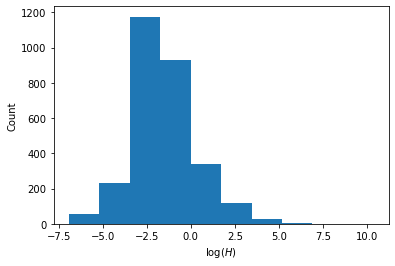

In [6]:
import numpy as np
import matplotlib.pyplot as plt

log_vals = np.log10(pd.pivot_table(measured, values='value', index='id')['value'])

plt.hist(log_vals)
plt.xlabel("$\log(H)$")
plt.ylabel("Count")
plt.show()

So we have a log normal distribution of values.

In [7]:
# id.1 references the chemical species id.
types_of_vals = np.log10(pd.pivot_table(df, values='value', index='id.1', columns='htype'))

## How well does the dataset provide predictions?
We want to see if the recalculations are useful ('R'), whether the Thermodynamical calculations are useful ('T'), and whether the estimated values are useful ('E').

These should be compared to the measured values.

In [66]:
from sklearn.metrics import mean_squared_error

In [74]:
methods = ['R', 'T', 'E']

for m in methods:
    method_df = types_of_vals[['M', m]].dropna()
    mse = mean_squared_error(method_df['M'], method_df[m])
    
    print("Method %s" % m)
    print("# of data points: ", len(method_df))
    print("MSE: ", mse)

Method R
# of data points:  49
MSE:  0.22719714372738573
Method T
# of data points:  84
MSE:  0.8350590095768446
Method E
# of data points:  8
MSE:  1.1888546837215463


So clearly, there isn't a ton of overlap, but when there is, the extrapolations from other temperatures are the most helpful.

NOTE: These mean squared errors use the log value of Henry's Law...so these seemingly small errors means 1 $\approx$ a factor of 10.

# Getting chemical properties
There are several chemical properties that will make getting results easier. The cells below handle getting that data using PubChemPy, a helpful package for pulling data from PubChem.

In [7]:
agg_by_htype = (df.drop(columns=['id', 'literature_id','id.1', 'formula'])
.groupby(by=['inchikey','species_id', 'iupac','htype']).mean()).reset_index()

In [8]:
measured_htype = agg_by_htype[agg_by_htype['htype'] == 'M']

In [10]:
len(set(measured_htype['species_id']))

1027

In [81]:
measured_htype.head()

,inchikey,species_id,iupac,htype,mindhr,subcat_id,value
4,AAPLIUHOKVUFCC-UHFFFAOYSA-N,4565,trimethylsilanol,M,NaN,55,0.070000
8,ABVVEAHYODGCLZ-UHFFFAOYSA-N,1654,1-tridecanamine,M,NaN,30,0.090000
29,AEMRFAOFKBGASW-UHFFFAOYSA-N,1421,hydroxyethanoic acid,M,4000.0,29,280.000000
38,AFABGHUZZDYHJO-UHFFFAOYSA-N,87,2-methylpentane,M,960.0,11,0.000013
57,AFYPFACVUDMOHA-UHFFFAOYSA-N,3670,chlorotrifluoromethane,M,2050.0,46,0.000009


In [87]:
import time
# Let's get all of the data about each of the elements

mol_weight = []
tpsa = [] # Topological Polar Surface Area
h_bond_donors = []
h_bond_acceptors = []
heavy_atom_count = []

all_data = []
# Columns
columns = [
     'canonical_smiles',
     'complexity', 
     'molecular_weight',
     'tpsa',
     'h_bond_acceptor_count',
     'h_bond_donor_count',
     'covalent_unit_count'
    ]

# For handling edge cases.
not_found = []
greater_than_one = []
for index, row in measured_htype.iterrows():
    inchikey = row['inchikey']
    
    compound = None
    if inchikey == 'inchikey':
        pass
    else:
        compound = pcp.get_compounds(inchikey, 'inchikey')
    
    # Handle edge cases
    if compound is None:
        not_found.append(row['iupac'])
        continue
    
    if len(compound) != 1:
        greater_than_one.append(compound)
        continue
        
    # Get the properties
    df_row = np.array([
        row['iupac'],
        row['inchikey'],
        row['value'],
    ])
    
    pubchem_data = compound[0].to_series()[columns].to_numpy()
    # Add the following rows
    all_data.append(list(np.append(row, pubchem_data)))
    time.sleep(1)

In [88]:
import joblib
joblib.dump(all_data, 'pubchem_data.joblib')

['pubchem_data.joblib']

In [90]:
len(all_data)

958

In [91]:
not_found

["4-(3',5'-dimethyl-3'-heptyl)-phenol(+)",
 "4-(3',5'-dimethyl-3'-heptyl)-phenol(-)",
 '3-nitrooxy-1-butanol',
 '4-nitrooxy-1-butanol',
 '4-nitrooxy-2-butanol',
 '4-nitrooxy-1-pentanol',
 '5-nitrooxy-2-pentanol',
 '(2R,4S)-2,4-pentanediol dinitrate',
 '(2R,4R)-2,4-pentanediol dinitrate',
 '(1R,2S)-1,2-cyclohexanediol dinitrate',
 '(1R,2R)-1,2-cyclohexanediol dinitrate',
 '(1R,3S)-1,3-cyclohexanediol dinitrate',
 '(1R,3R)-1,3-cyclohexanediol dinitrate',
 '(1R,2R)-1,2-cycloheptanediol dinitrate',
 'PFBHA-methanal',
 'PFBHA-ethanal',
 'PFBHA-propanone',
 'PFBHA-butanone',
 'PFBHA-2-pentanone',
 'PFBHA-hexanal',
 'PFBHA-octanal',
 'PFBHA-decanal',
 'PFBHA-propenal',
 'PFBHA-crotonaldehyde',
 'PFBHA-benzaldehyde',
 'PFBHA-4-methyl-benzaldehyde',
 'PFBHA-9-fluorenone',
 'PFBHA-ethanedial',
 'PFBHA-1-hydroxypropanone',
 'PFBHA-3-hydroxy-3-methyl-2-butanone',
 '1,1,2-trichloroethane-d3',
 '1,2-dichloropropane-d6',
 '2-bromo-3,5-dichloro-1-methoxybenzene',
 '4-bromo-3,5-dichloro-1-methoxybenzen

In [107]:
greater_than_one[0][1].to_series()['canonical_smiles']

'C(C(=O)[O-])[OH2+]'

In [128]:
compounds_to_check = []
for compounds in greater_than_one:
    if len(compounds) > 0:
        for c in compounds:
            compounds_to_check.append(c)

compounds_to_check

[Compound(757),
 Compound(3698251),
 Compound(8253),
 Compound(409301),
 Compound(284),
 Compound(18971002),
 Compound(6422),
 Compound(23138861),
 Compound(996),
 Compound(20488062),
 Compound(743),
 Compound(23322899),
 Compound(14917),
 Compound(16211014),
 Compound(24085),
 Compound(5284416),
 Compound(139036534),
 Compound(784),
 Compound(22326046),
 Compound(6511),
 Compound(101498847),
 Compound(176),
 Compound(21980959),
 Compound(160748163),
 Compound(402),
 Compound(18779926),
 Compound(783),
 Compound(58838673),
 Compound(243),
 Compound(20144841),
 Compound(6421),
 Compound(23223116)]

In [129]:
c = compounds_to_check[0]

In [139]:
name = c.to_series(['iupac_name'])['iupac_name']

In [141]:
row = measured_htype[measured_htype['iupac'] == name]

In [142]:
len(row)

0

In [145]:
# Get values for compounds with more than one result
for compound in compounds_to_check:
    name = compound.to_series(['iupac_name'])['iupac_name']
    row = measured_htype[measured_htype['iupac'] == name]
    
    if len(row) == 0:
        continue
        
    # Get the properties
    df_row = np.array([
        row['iupac'],
        row['inchikey'],
        row['value'],
    ])
    
    pubchem_data = compound.to_series()[columns].to_numpy()
    # Add the following rows
    all_data.append(list(np.append(row, pubchem_data)))

In [151]:
new_df = pd.DataFrame(all_data, 
                     columns = [
                         'inchikey', 
                         'species_id',
                         'iupac',
                         'htype','mindhr',
                         'subcat_id',
                         'value',
                         'canonical_smiles',
                         'complexity',
                         'molecular_weight',
                         'tpsa',
                         'h_bond_acceptor_count',
                         'h_bond_donor_count',
                         'covalent_unit_count'
                     ])

In [153]:
new_df.to_csv('./data/clean_henrys.csv')

# Final results of this effort

I created a CSV with the cleaned up data which now has the cannonical SMILES representation of the data, along with a few physical properties that can be applied to try to create a first-pass method for predicting Henry's law.